In [1]:
import pandas as pd

df = pd.read_csv("IMDB_Dataset.csv")

In [2]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
df[df['review'].duplicated()]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [5]:
df = df.drop_duplicates(subset='review', keep='first')

In [6]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [7]:
X = df['review']
y = df['sentiment']

In [8]:
from sklearn.model_selection import train_test_split

random_state = 101
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=random_state, stratify=y_train_val)

In [9]:
y_test.value_counts()

sentiment
positive    2489
negative    2470
Name: count, dtype: int64

In [10]:
y_train = y_train.map({'negative': 0, 'positive': 1}).values
y_val = y_val.map({'negative': 0, 'positive': 1}).values
y_test = y_test.map({'negative': 0, 'positive': 1}).values

In [11]:
import re
import contractions
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import words
from spacy.lang.en.stop_words import STOP_WORDS
from symspellpy.symspellpy import SymSpell, Verbosity


# Initialize components
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "frequency_dictionary_en_82_765.txt"
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Custom stopwords
stopwords_to_keep = {
    "not", "no", "nor", "never", "neither",
    "but", "though", "although", "however", "yet",
    "very", "too", "much", "more", "most", "almost",
    "should", "could", "might", "may", "would", "can", "must",
    "only", "against", "because", "than"
}
custom_stopwords = STOP_WORDS - stopwords_to_keep

# Set of valid words
valid_words = set(words.words())

# Get WordNet POS tag
def get_wordnet_pos(spacy_tag):
    if spacy_tag == "ADJ":
        return wordnet.ADJ
    elif spacy_tag == "VERB":
        return wordnet.VERB
    elif spacy_tag == "NOUN":
        return wordnet.NOUN
    elif spacy_tag == "ADV":
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Correct spelling using SymSpell
def symspell_correct(word):
    suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
    return suggestions[0].term if suggestions else word

# Preprocess text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    #print("After lowering:", text)

    # Expand contractions
    text = contractions.fix(text)
    #print("After contractions:", text)

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #print("After non-alphabetic characters removal:", text)

    # Tokenize text
    tokens = word_tokenize(text)
    #print("Tokens:", tokens)

    # Rpelling correction
    tokens = [symspell_correct(word) for word in tokens]
    #print("After SymSpell:", tokens)

    # Remove stopwords
    tokens = [word for word in tokens if word not in custom_stopwords]
    #print("After Stopword Removal:", tokens)

    # Use spaCy for POS tagging
    doc = nlp(" ".join(tokens))
    #pos_tags = [(token.text, token.pos_) for token in doc]
    #print("POS Tags:", pos_tags)

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token.text, get_wordnet_pos(token.pos_)) for token in doc]
    #print("After Lemmatization:", tokens)

    # Remove invalid words
    tokens = [word for word in tokens if word in valid_words]
    #print("Valid Tokens:", tokens)

    return tokens

In [12]:
X_train_preprocessed = X_train.apply(preprocess_text)
X_val_preprocessed = X_val.apply(preprocess_text)
X_test_preprocessed = X_test.apply(preprocess_text)

In [13]:
import numpy as np

embedding_dim = 100
glove_path = "glove.6B.100d.txt"

embeddings_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_preprocessed)
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_seq = tokenizer.texts_to_sequences(X_train_preprocessed)
X_val_seq = tokenizer.texts_to_sequences(X_val_preprocessed)
X_test_seq = tokenizer.texts_to_sequences(X_test_preprocessed)

max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=False))

model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))


model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_pad, y_train, 
                    epochs=50, 
                    batch_size=32,
                    validation_data=(X_val_pad, y_val),
                    callbacks=[early_stopping])

Epoch 1/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.7013 - loss: 0.5647 - val_accuracy: 0.8131 - val_loss: 0.4167
Epoch 2/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.8115 - loss: 0.4174 - val_accuracy: 0.8342 - val_loss: 0.3693
Epoch 3/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.8297 - loss: 0.3787 - val_accuracy: 0.8293 - val_loss: 0.3758
Epoch 4/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.8463 - loss: 0.3488 - val_accuracy: 0.8490 - val_loss: 0.3361
Epoch 5/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.8589 - loss: 0.3254 - val_accuracy: 0.8584 - val_loss: 0.3343
Epoch 6/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8664 - loss: 0.3094 - val_accuracy: 0.8622 - val_loss: 0.3185
Epoch 7/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8754 - loss: 0.2924 - val_accuracy: 0.8660 - val_loss: 0.3164
Epoch 8/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.8826 -

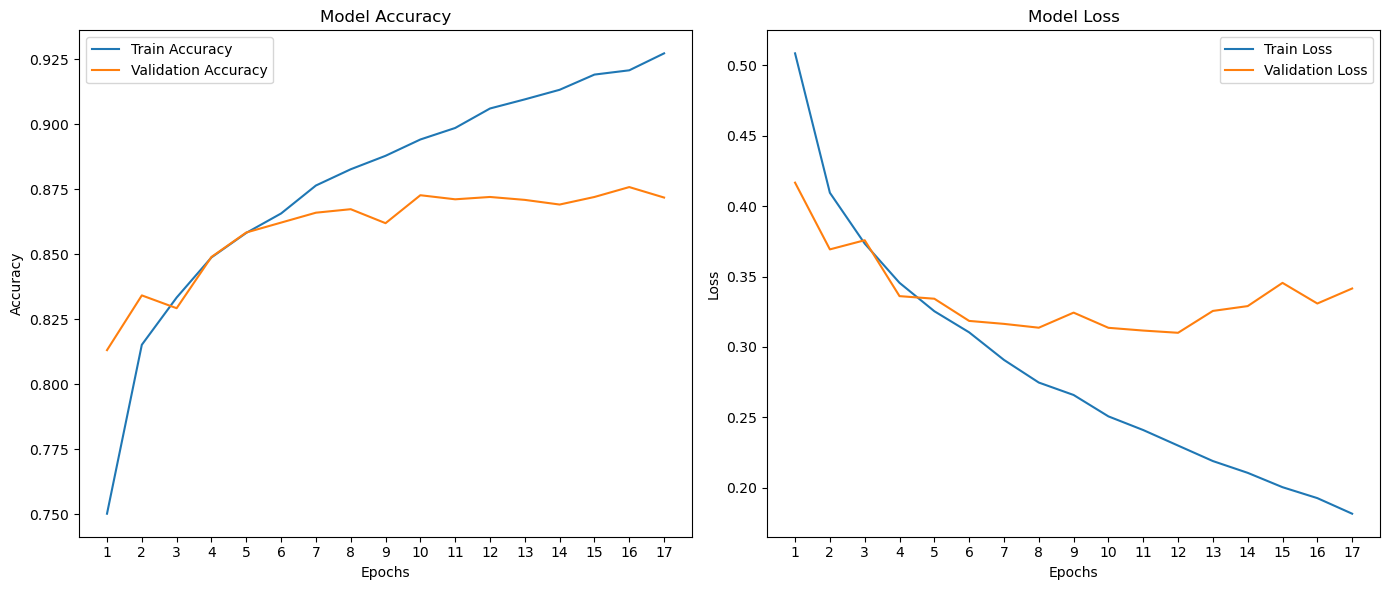

In [21]:
import matplotlib.pyplot as plt

total_epochs = len(history.history['accuracy'])
xticks_range = range(1, total_epochs + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(xticks_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(xticks_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xticks(xticks_range)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(xticks_range, history.history['loss'], label='Train Loss')
plt.plot(xticks_range, history.history['val_loss'], label='Validation Loss')
plt.xticks(xticks_range)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step


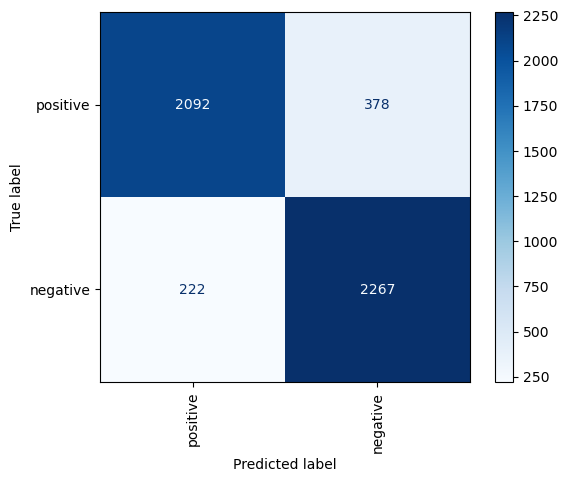

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['sentiment'].unique())
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [23]:
import pickle

X_preprocessed = X.apply(preprocess_text)
tokenizer_final = Tokenizer()
tokenizer_final.fit_on_texts(X_preprocessed)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer_final, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index_final = tokenizer_final.word_index
embedding_matrix_final = np.zeros((len(word_index_final) + 1, embedding_dim))

for word, i in word_index_final.items():
    embedding_vector_final = embeddings_index.get(word)
    if embedding_vector_final is not None:
        embedding_matrix_final[i] = embedding_vector_final

X_seq = tokenizer_final.texts_to_sequences(X_preprocessed)
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post')
y = y.map({'negative': 0, 'positive': 1}).values

In [24]:
model_final = Sequential()

model_final.add(Embedding(input_dim=len(word_index_final) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix_final],
                    trainable=False))

model_final.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))

model_final.add(Dropout(0.2))

model_final.add(Dense(1, activation='sigmoid'))

model_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

val_loss = history.history['val_loss']

optimal_total_epochs = val_loss.index(min(val_loss)) + 1

model_final.fit(X_pad, y, epochs=optimal_total_epochs, batch_size=32)

Epoch 1/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 67s 41ms/step - accuracy: 0.6979 - loss: 0.5732
Epoch 2/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.8160 - loss: 0.4069
Epoch 3/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.8384 - loss: 0.3679
Epoch 4/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8496 - loss: 0.3466
Epoch 5/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - accuracy: 0.8590 - loss: 0.3255
Epoch 6/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.8696 - loss: 0.3029
Epoch 7/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.8775 - loss: 0.2882
Epoch 8/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.8849 - loss: 0.2752
Epoch 9/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.8919 - loss: 0.2610
Epoch 10/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 63s 41ms/step - accuracy: 0.8974 - loss: 0.2490
Epoch 11/12
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - accuracy: 0.9020 - loss: 0.2394
Epoch 12

In [25]:
import joblib

joblib.dump(model_final, 'model.pkl')

['model.pkl']